# Reddit Project: Data Analysis
---

**Note: This study contains 3 different notebook files. 1: Data Acquisition, in which training data is collected, manipulated, and drawn.  2: Data Analysis (this file), in which the body of the study is conducted. 3: Test Data Acquisition, which test data samples are drawn for the purpose of assessing the effectiveness of the trained models in this study to generalize to new data.

Package Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

#From stackoverflow/sklearn documentation 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

## Problem Statement
---
My client is a psychological research group. They are in the beginning stages of gathering data, for a study invovling both the extent of, and psychological impact of, an ever increasing sense of division and hostility revolving around politics. 

In this study, an attempt to statistically quanitfy such a level of political division will be attempted. The data utilized involves online communication and news gathering from the online website, reddit. In such communities, a true level of potential hostility can be established, as users may feel more unibhibited in expressing negative or divisive opinions than they might be in personal discussions. The reddit community has a large number of "subreddits," sub communities revolving around a singular topic, ranging from scientific study to philosophical discussions to photographs of cats.

For the sake of political ideological comparison, two subreddits will be chosen along the right and left leaning portions of the political spectrum. Politcal parties are not being utilized (Republicans and Democrats), as this study is less concerned with political parties and more the potential effects of strong political ideologies.
  - Initially, the two subreddits chosen were Conservative and Liberal. Upon analysis, however, the Liberal subreddit was far less active, leading to a large imbalance in my dataset. I therefore decided to use a different left leaning subreddit called Progressive, as it proved to be far more active.

The methodology of assesing the extent of division will revolve around two measurable factors. The first is an analysis of the overlap of news sources. Are these two communities getting their information from the same sources? If so, to what ratio? A lack of overlap in sources of news consumption could be an indicator of further division among both ideologies. 

The second factor is an analysis of topics discussed. As this is a data science study utilizing very large quantities of text data, a reading assessment would not be feasible. Rather, an analysis of word count and importance will be conducted. A sentiment analysis of bodies of text by reddit post will also be attempted to the extent possible given data size limitations.

My client is likewise interested in the ability to algorithmically predict which subreddit a post belongs to, to serve as evidence of these correlations.

- Specifically analyze the sentiment of comments and/or titles with certain buzzwords, like Trump, Biden, RBG, Amy Coney Barrett, coronavirus, COVID19, antifa, BLM, racism, riots, to see 1) who mentions each more, and 2) their sentiment regarding them.

## Reading in the Data
---

In [2]:
reddit = pd.read_csv('Data/redditproject.csv')

In [3]:
comments = pd.read_csv('Data/comments_clean.csv')
comments.drop(columns = 'Unnamed: 0', inplace = True)

Later, let's use a lemmatizer to cut out the https://www. part. then split from / and keep only the first part for the url column. Then we can find out what sites are most commonly visited from each subreddit.

Other ideas: use countvectorizer to see what the highest used words are, but model off of TfidfVectorizer to find the words used by importance weight.

In [4]:
reddit.head(4)

,title,score,id,url,comms_num,created,body,subreddit,gilded_user
0,Thousands of Latinos Gather in Miami For Anti-...,3,jdnapu,https://www.thegatewaypundit.com/2020/10/thous...,1,1.603081e+09,NaN,Conservative,0
1,Camera Catches the Incredible Moment Dem Rep W...,3,jdn9ta,https://www.conservativenewsdaily.com/camera-c...,0,1.603080e+09,NaN,Conservative,0
2,New Data Analysis Finds 353 Counties With 1.8 ...,3,jdn6mm,https://www.theepochtimes.com/new-data-analysi...,0,1.603080e+09,NaN,Conservative,0
3,Meanwhile in New Zealand where their leadershi...,0,jdn5qc,https://www.reddit.com/r/sports/comments/jdgrk...,3,1.603080e+09,NaN,Conservative,0


## Where do redditors get their news?
---

While reddit is not necessarily representative of the general population of Americans in these political ideologies, the sourcing of news on the site can still be an interesting indicator of how well these groups overlap.

In [5]:
#Creating a sites column that eradicates the url noise
reddit['sites'] = reddit.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

In [6]:
#I will undoubtedly need these multiple times, so I will go ahead and filter them now.
cons = reddit[reddit.subreddit == 'Conservative']
progs = reddit[reddit.subreddit == 'Progressive']

Note on sites chart below: the first index is is dropped because (for both subreddits) the first index is a reddit image source.

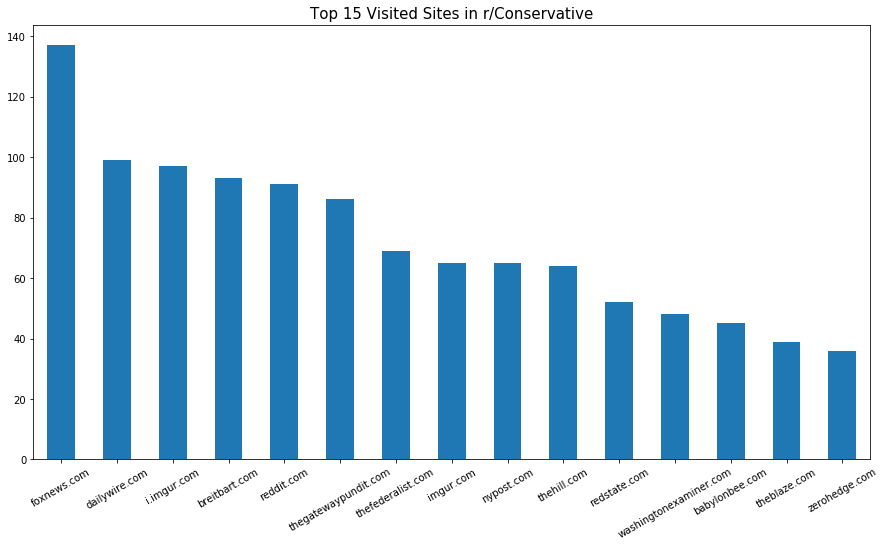

In [7]:
cons.sites.value_counts()[1:16].plot.bar(figsize = (15, 8), rot = 30)
plt.title('Top 15 Visited Sites in r/Conservative', fontsize = 15);
#plt.savefig('Images/cons_sites.png')

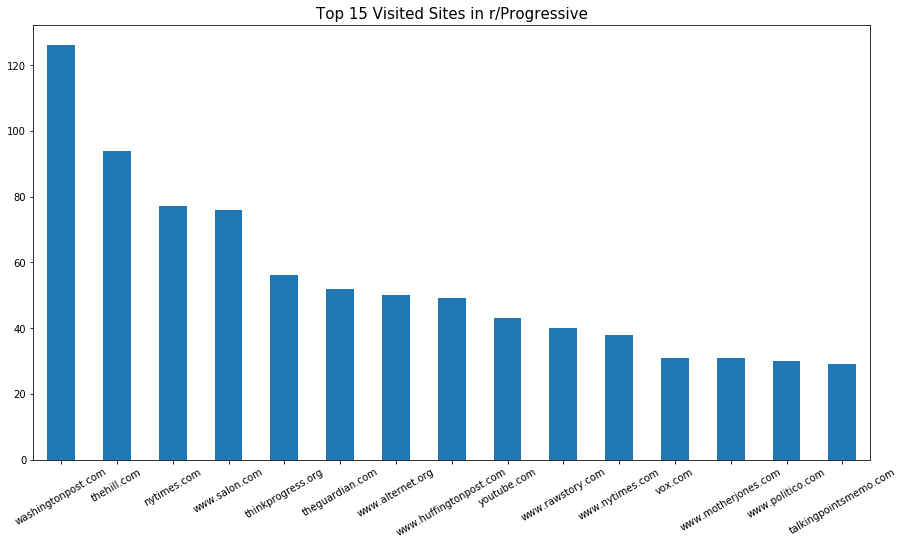

In [8]:
progs.sites.value_counts()[1:16].plot.bar(figsize = (15, 8), rot = 30)
plt.title('Top 15 Visited Sites in r/Progressive', fontsize = 15);
#plt.savefig('Images/prog_sites.png')

Not a single one of the top visited sites in either subreddit is referenced in the top 15 sites of the other subreddit. But is this just from top sites, or does this trend continue on throughout the entire dataset?

In [9]:
def sites_in_common(cons, progs):
    counter = 0
    sites = set()
    for site in cons.sites:
        if progs['sites'].str.contains(site).any():
            sites.add(site)
    return sites

In [10]:
big_set = sites_in_common(cons, progs)

In [11]:
print(len(big_set)) #The first entry is a 'junk' entry, but there are probably some in the sites as well
print(reddit.sites.nunique())

len(big_set)/ reddit.sites.nunique()

123
1116


0.11021505376344086

There were only 122 sites out of all of the 1116 news sites used as reddit news sources that are shared among the different political subreddits. That accounts for 11% of all of the unique news sites that are in the dataset. This bodes poorly for a peaceful America, but will likely be a very helpful for me in a predictive algorithm.

## Comment Sentiment Analysis
---

The following dataframe is a subset of the main dataframe. Half of the dataframe was selected for time constraints, and thus were sorted by largest number of comments. Sentiment analysis on the comments was done in the data acquisition notebook. Of note, the values of subreddit are much more imbalanced towards conservatives, indicating that commenters on the conservative subreddit are likely to be generally more active.

Comments were done primarily on the comments, avoiding the title and body of posts. The reason for this is that a sentiment analysis was of interest as a reflection of the community at large, and less of the words of one poster. Furter, most of the post titles are in fact various article headlines from different news sources, and as such, a sentiment analysis of the title would amount to little more than a reflection of the use of positive or negative words in headlines of various journalists, which is not relevant to this study.

In [12]:
#comments.set_index('id', inplace = True)

In [13]:
comments.head()

,id,comments,subreddit,neg,neu,pos,compound
0,j2bxs0,"[""Tired of reporting this thread? Debate us on...",Conservative,0.162,0.652,0.186,0.9992
1,ivh84e,['We are hosting a polite discussion of RBG an...,Conservative,0.166,0.556,0.277,1.0000
2,j3oh32,"[""Tired of reporting this thread? Debate us on...",Conservative,0.161,0.607,0.232,1.0000
3,i0ltok,['Actual Title - **Donald Trump suggests delay...,Conservative,0.173,0.686,0.141,-0.9998
4,hi426n,"['what the fuck is cumtown lmao', 'Glad to see...",Conservative,0.175,0.663,0.162,-0.9988


So compound will give the overall sentiment, but also look into the positive and negative values themselves. Create a list of scores of positive, negative, and compound for each row, then create a new column of mean and median values of each.

In [14]:
comments.groupby('subreddit')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
Conservative,2056.0,-0.065146,0.970645,-1.0,-0.99920,-0.8569,0.9977,1.0
Progressive,932.0,0.122670,0.942619,-1.0,-0.97855,0.8406,0.9941,1.0


The compound scores seems problematic, in that it continuously "snaps" toward -1 or 1. I'm not sure can trust these results to be meaningful.

In [15]:
comments.groupby('subreddit')['pos'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
Conservative,2056.0,0.162839,0.030582,0.058,0.14400,0.162,0.180,0.319
Progressive,932.0,0.160868,0.035496,0.049,0.13775,0.161,0.184,0.294


In [16]:
comments.groupby('subreddit')['neg'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
Conservative,2056.0,0.161911,0.039511,0.033,0.13575,0.159,0.185,0.357
Progressive,932.0,0.149964,0.048953,0.000,0.11500,0.143,0.179,0.426


In [17]:
def ttest_sentiment(score):
    con = comments[comments.subreddit == 'Conservative'][score]
    prog = comments[comments.subreddit == 'Progressive'][score]
    ttest, pval = ttest_ind(con, prog)
    if pval < 0.05:
        return f'{score} is significantly different among Conservatives and Progressives'
    return f'There is no evidence here that {score} is significantly different between Conservatives and Progressives'

In [18]:
sents = ['neu', 'neg', 'pos', 'compound']
for pers in sents:
    print(ttest_sentiment(pers))

neu is significantly different among Conservatives and Progressives
neg is significantly different among Conservatives and Progressives
There is no evidence here that pos is significantly different between Conservatives and Progressives
compound is significantly different among Conservatives and Progressives


In [19]:
conservative_comments = comments[comments.subreddit == 'Conservative']
progressive_comments = comments[comments.subreddit == 'Progressive'].reset_index()

In [20]:
def sentiment_plot(df, saved = False):
    plt.figure(figsize = (12, 13))
    plt.suptitle(f'{df.subreddit[0]} Sentiment Analysis Score Distributions', fontsize = 14)
    
    ax = plt.subplot(2, 2, 1)
    plt.hist(df.pos, bins = 30)
    plt.title(f'{df.subreddit[0]} Positive Score Distribution', fontsize = 12)
    
    ax1 = plt.subplot(2, 2, 2)
    plt.hist(df.neg, bins = 30)
    plt.title(f'{df.subreddit[0]} Negative Score Distribution', fontsize = 12)
    
    ax2 = plt.subplot(2, 2, 3)
    plt.hist(df.neu, bins = 30)
    plt.title(f'{df.subreddit[0]} Neutral Score Distribution', fontsize = 12)
    
    ax3 = plt.subplot(2, 2, 4)
    plt.hist(df['compound'], bins = 30)
    plt.title(f'{df.subreddit[0]} Compound Score Distribution', fontsize = 12);
    
    if saved:
        plt.savefig(f'Images/{df.subreddit[0]}_sentiment_distribution.png')

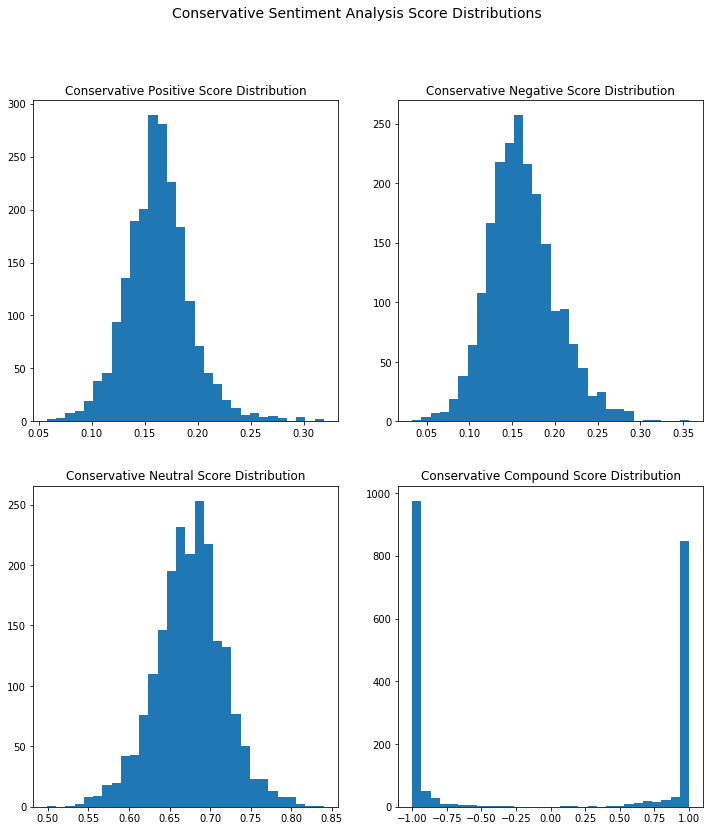

In [21]:
sentiment_plot(conservative_comments, saved = True)

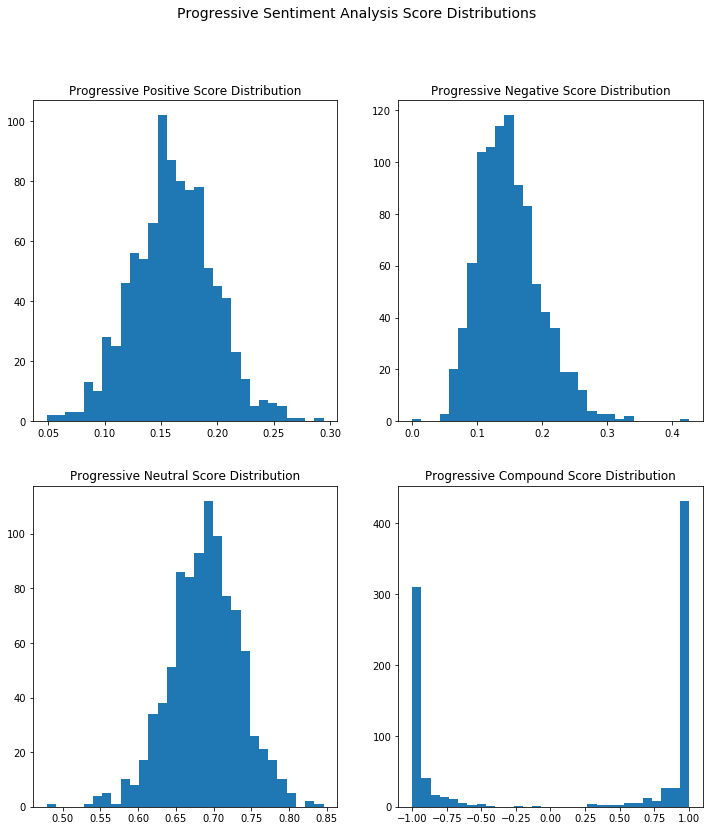

In [22]:
sentiment_plot(progressive_comments, saved = True)

Honestly, nobody looks good here. Both have a lot of positive and negative scores in the comments. The compound scores are a bit problematic, however, as they tend to sharply turn towards -1 or 1 in extremes, possibly due to the large number of words. (Of note, stopwords were removed)

- Interestingly, the conservative subreddit has higher scores values in the 5 number summary in the sentiment analysis of positive scores (though not by a lot) compared to the progressive subreddit. 

- The conservative subreddit also has slightly higher negative scores for most of the 5 number summary, though the maximum negative score of the progressive subreddit is a higher value.

Some caveats - people other than subscribers can post comments, so the sentiment of comments may not always reflect the people who post or even frequently view the various subreddits. Both subreddits appear to periodically complain of "brigading," where people opposed to their political views leave negative or even abusive comments. Whether this assertion is true, or part of a potentially interesting psychological phenomenon involving highly politically active online users on both sides of the political spectrum, is unknown, but perhaps an area that will warrant further investigation.

While this was intriguing in an the sense of identifying the sentiment scores, the values are far too close to one another to be of much help in utilizing a model for predictive purposes.

## Analysis of all text words (including posts and body if available)
---

This will pass only the text for now as a vector. In modelling (if decided to use the countvectorizer) we can set training data up as such.

In [23]:
reddit = reddit.merge(comments[['id', 'comments']],how = 'outer', left_on = 'id', right_on = 'id')

In [24]:
reddit['text'] = reddit.apply(lambda row: row.title + row.body + row.comments if not pd.isnull(row.body) and 
                              not pd.isnull(row.comments) else row.title + row.comments if not 
                              pd.isnull(row.comments) else row.title + row.body if not pd.isnull(row.body) 
                              else row.title, axis = 1)

In [25]:
#re-calling so that the correct columns will exist
cons = reddit[reddit.subreddit == 'Conservative']
progs = reddit[reddit.subreddit == 'Progressive']

In [26]:
#Utilizing countvecotrizer to see top words (and analyze top used words)
cvec = CountVectorizer(stop_words = 'english', max_features = 5000)

Of note - I am ok with not splitting the data up to this point before fitting, as I will be pulling in my own test data later on. All of this data will be trained on later.

**Which words do each subreddit use the most?**

In [27]:
all_words = cvec.fit_transform(reddit.text)

In [28]:
all_words_df = pd.DataFrame(all_words.todense(), 
                          columns=cvec.get_feature_names())

In [29]:
all_words_df['subreddit'] = reddit.subreddit

In [30]:
con_words = all_words_df[all_words_df.subreddit == 'Conservative'].drop(columns = 'subreddit')
prog_words = all_words_df[all_words_df.subreddit == 'Progressive'].drop(columns = 'subreddit')

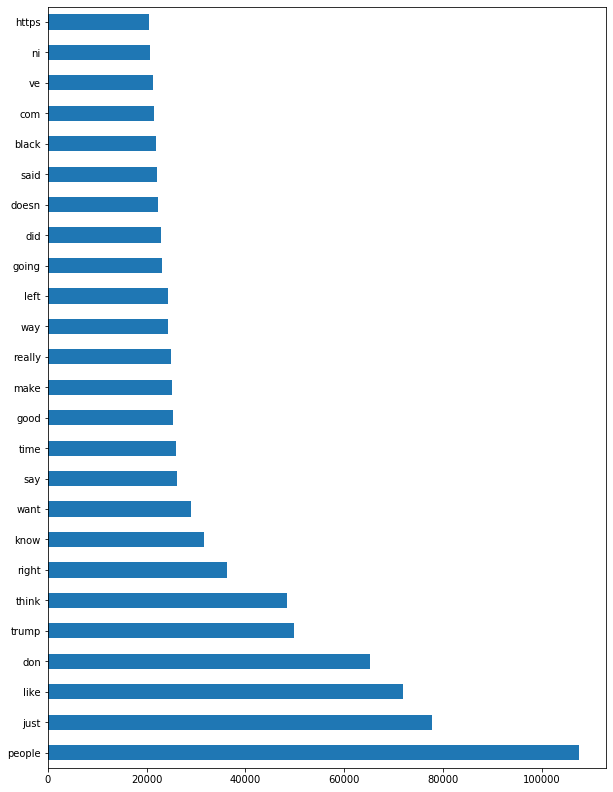

In [31]:
all_words_df.drop(columns = 'subreddit').sum().sort_values(
    ascending = False).head(25).plot.barh(figsize = (10, 14));

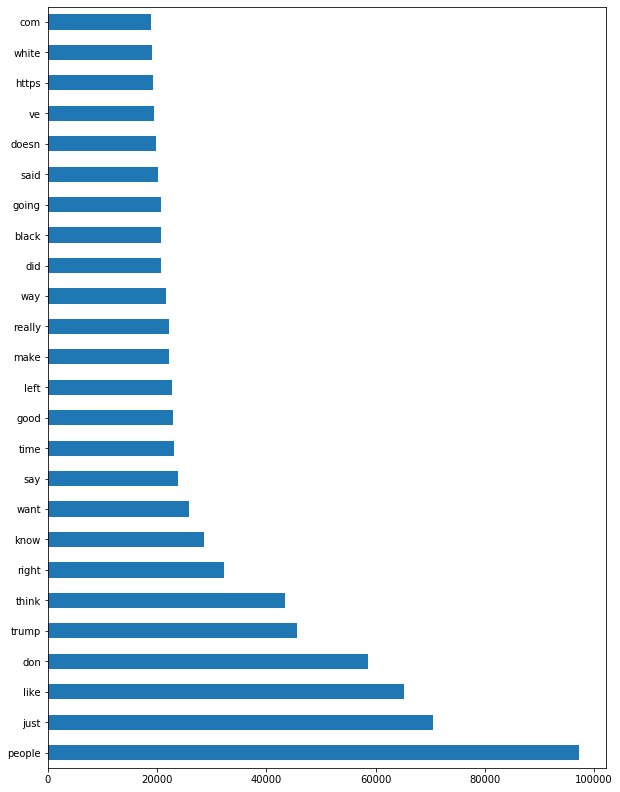

In [32]:
con_words.sum().sort_values(ascending = False).head(25).plot.barh(figsize = (10, 14));

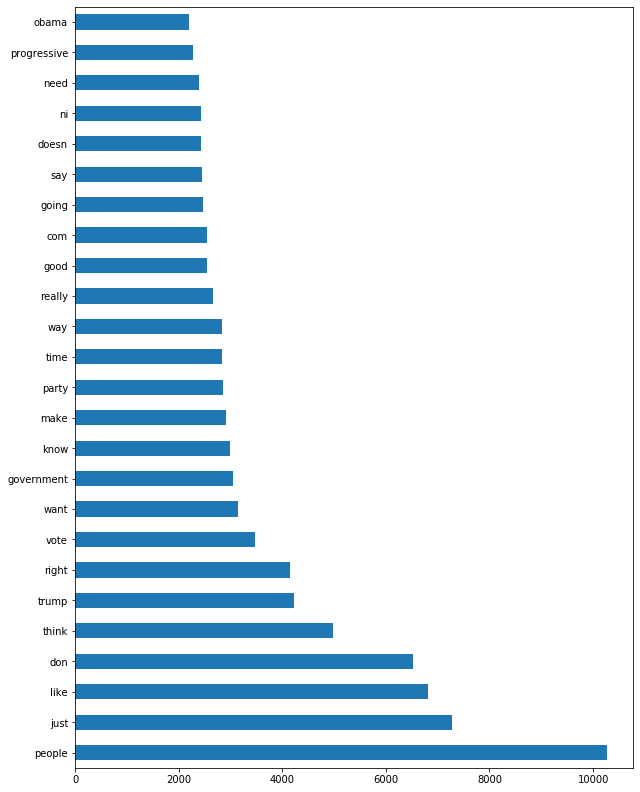

In [33]:
prog_words.sum().sort_values(ascending = False).head(25).plot.barh(figsize = (10, 14));

Looking at the sum of the top words by each subreddit, a clear issue is that there are FAR more words in the conservative subreddit than in the progressive subreddit - they are both almost equally active in terms of posting, but it appears that user commenting is much more common in the conservative subreddit. 

In terms of analyzing frequented words, this is an important caveat for comparison. It is very possible a word with identical counts between the subreddits is actually an indicator of the progressive subreddit utilizing that word more in their typical comments.

## Analysis of words specifically unique to each subreddit
---

Utilizing TfidfVecotrizer()

- Note: Because this is a TF-IDF word analysis, it is important to state that these are not word counts, but rather a reflection of importance to each document the given list of words are. I am using this for two reasons:

  1) As an analysis of the importance these various words play in each reddit community, high scoring words can indicate what "matters" to the political thoughts of people along the political spectrum. Having little to no similarity in level of importance would further indicate the deep division among both parties.
  
  2) Comparisons of pure word counts are somewhat difficult to confidently report on, given the the far larger corpus of words in the conservative subreddit (as they comment far more often). Utilizing a weighted count can show a more "pure" comparison of key political words in a way mitigates this imbalance. This will also be helpful in efforts of modelling data, for the same reasons.

In [34]:
tvec = TfidfVectorizer(stop_words = 'english', max_features = 5000)

In [35]:
all_words_weight = tvec.fit_transform(reddit.text)

In [36]:
weighted_df = pd.DataFrame(all_words_weight.todense(), 
                          columns=tvec.get_feature_names())
weighted_df['subreddit'] = reddit.subreddit

In [37]:
con_words = weighted_df[weighted_df.subreddit == 'Conservative'].drop(columns = 'subreddit')
prog_words = weighted_df[weighted_df.subreddit == 'Progressive'].drop(columns = 'subreddit')

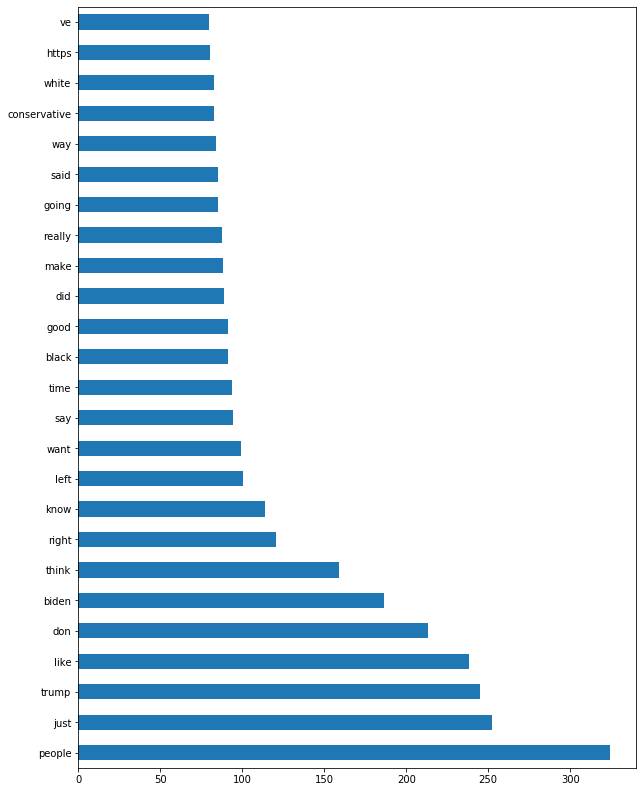

In [38]:
con_words.sum().sort_values(ascending = False).head(25).plot.barh(figsize = (10, 14));

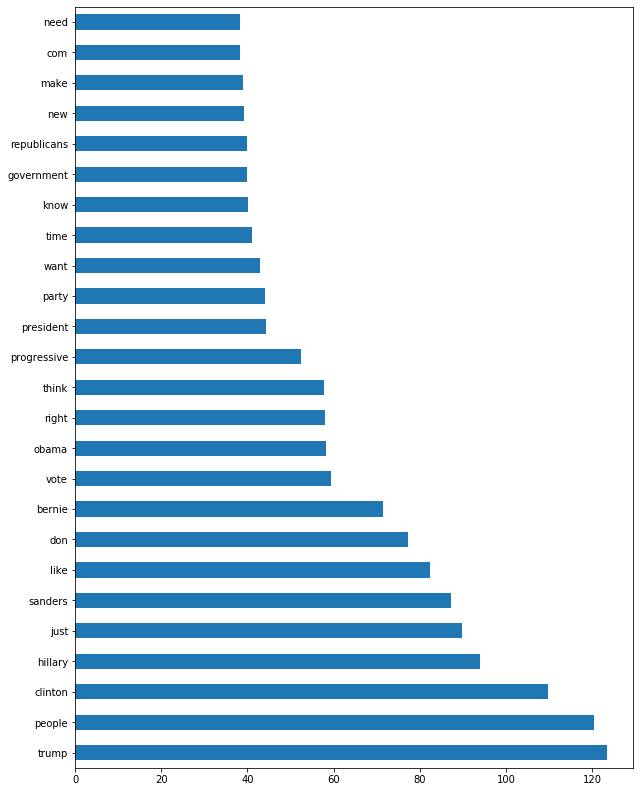

In [39]:
prog_words.sum().sort_values(ascending = False).head(25).plot.barh(figsize = (10, 14));

**Next up: how active are both subreddits? Look at comment lengths and 5 # summaries. Look also at karma scores. If these have any distinct values, perhaps they can be used to help identify subreddit origins.**

In [40]:
def bar_plot_words(con, prog, word):
    word_list = [con[word].sum(), prog[word].sum()]
    labels = ['Conservatives', 'Progressives']
    plt.figure(figsize = (8, 6))
    plt.bar(labels, word_list)
    plt.ylabel(f'Word Count: {word}')
    plt.title(f'Weighted Word Count:{word.title()} by subreddit\nConservative:{word_list[0]}, Progressive:{word_list[1]}');
    #plt.savefig(f'Images/{word}_plot.png')

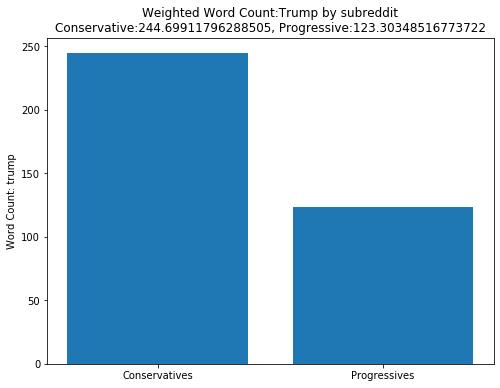

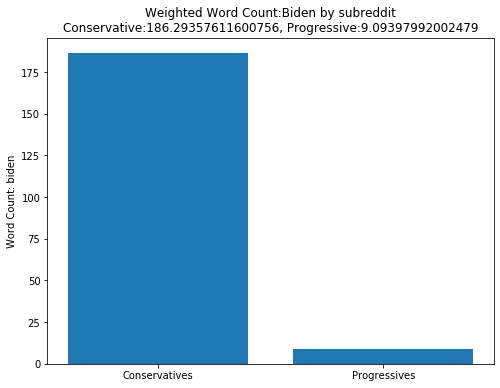

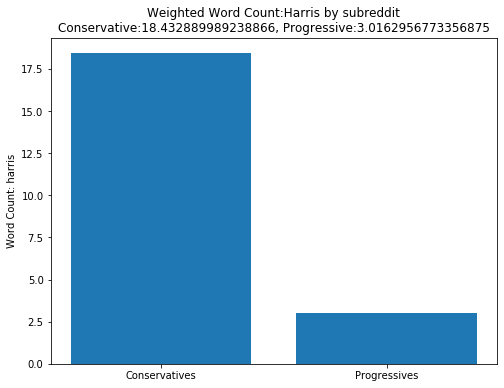

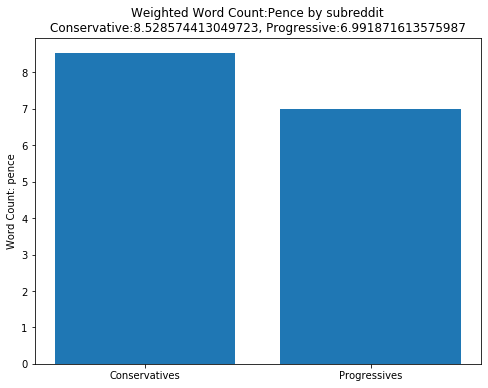

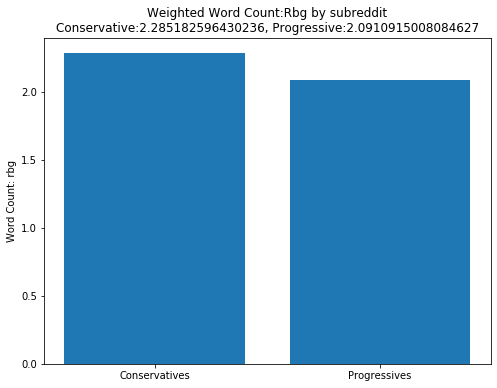

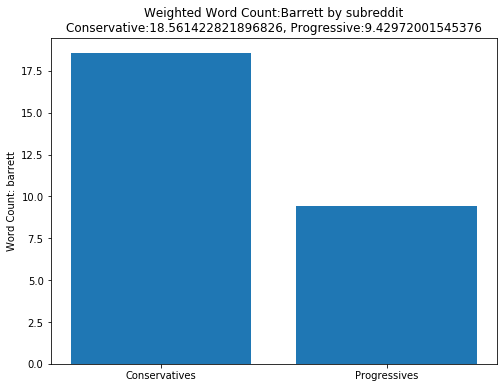

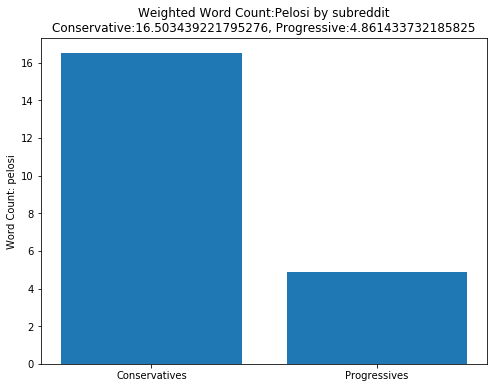

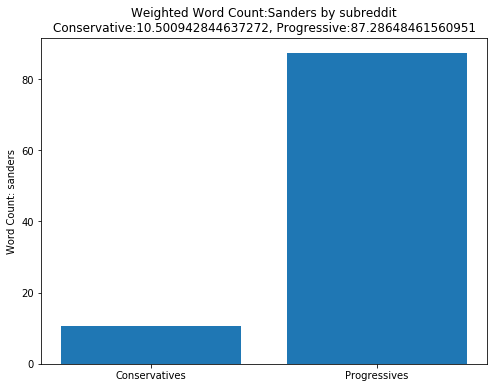

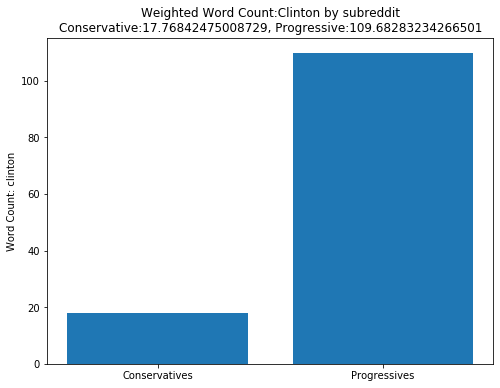

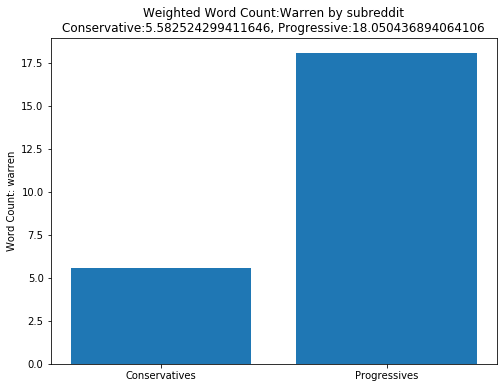

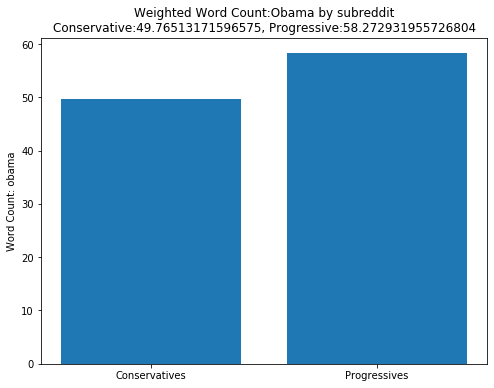

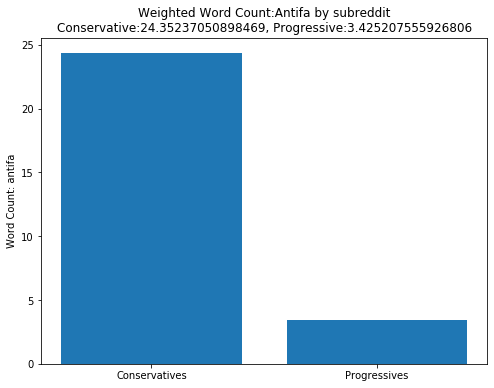

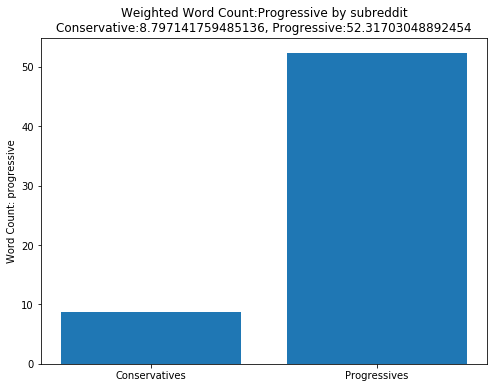

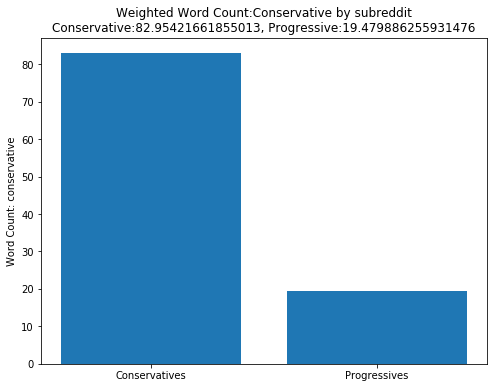

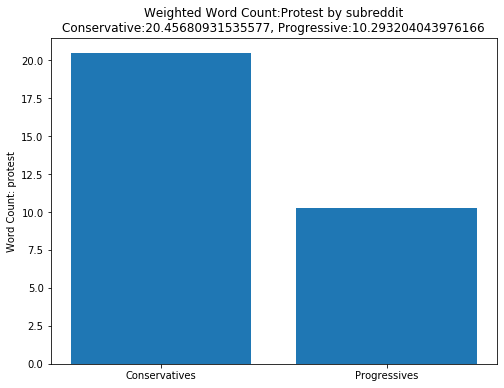

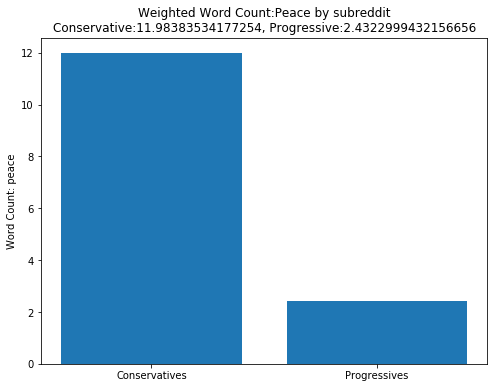

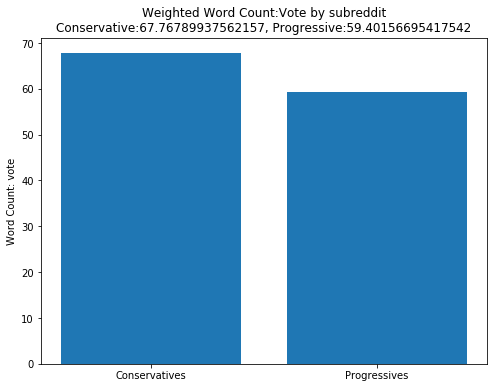

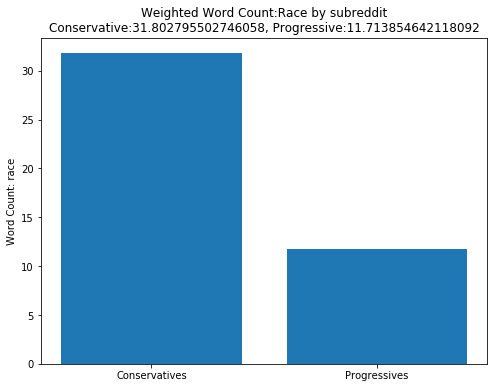

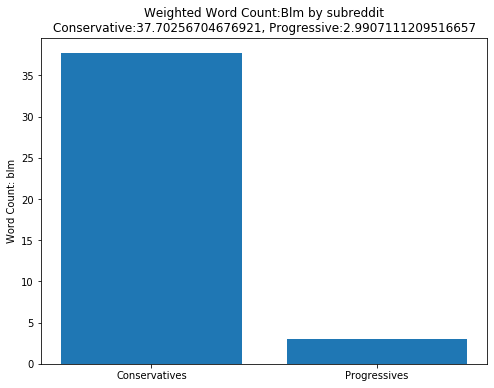

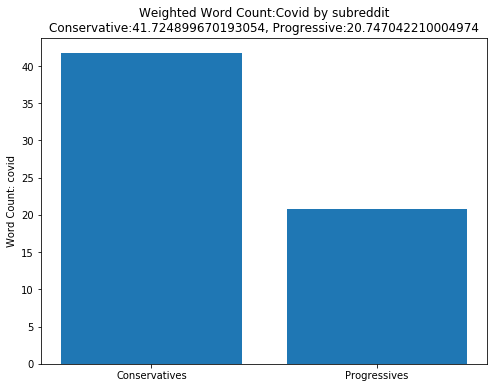

In [41]:
words_analysis = ['trump','biden', 'harris', 'pence', 'rbg', 'barrett', 'pelosi', 'sanders', 'clinton',
                  'warren', 'obama', 'antifa','progressive', 'conservative','protest', 
                  'peace', 'vote', 'race', 'blm', 'covid']
for word in words_analysis:
    bar_plot_words(con_words, prog_words, word)

In [42]:
con_words.shape, prog_words.shape, weighted_df.shape

((3058, 4999), (2919, 4999), (5977, 5000))

## Activity of both subreddits
---

In [43]:
reddit.comms_num.describe()

count     5977.000000
mean       145.481847
std        446.988720
min          0.000000
25%          3.000000
50%         15.000000
75%        102.000000
max      21909.000000
Name: comms_num, dtype: float64

In [44]:
cons.comms_num.describe()

count     3058.000000
mean       268.034009
std        598.886211
min          0.000000
25%          9.000000
50%         63.500000
75%        375.000000
max      21909.000000
Name: comms_num, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


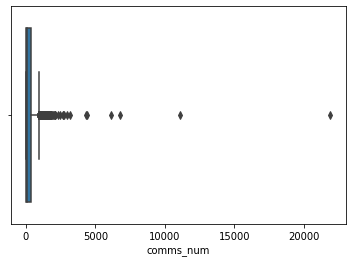

In [45]:
sns.boxplot(cons.comms_num);

In [46]:
progs.comms_num.describe()

count    2919.000000
mean       17.093868
std        34.716566
min         0.000000
25%         1.000000
50%         6.000000
75%        20.000000
max       738.000000
Name: comms_num, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


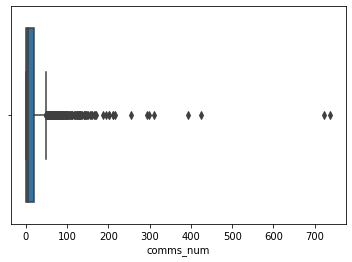

In [47]:
sns.boxplot(progs.comms_num);

In [48]:
reddit.score.describe()

count     5977.000000
mean      1018.108583
std       2097.166387
min          0.000000
25%          5.000000
50%        100.000000
75%        479.000000
max      47729.000000
Name: score, dtype: float64

In [49]:
cons.score.describe()

count     3058.000000
mean      1838.830608
std       2680.700672
min          0.000000
25%         17.000000
50%        183.500000
75%       3583.750000
max      47729.000000
Name: score, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


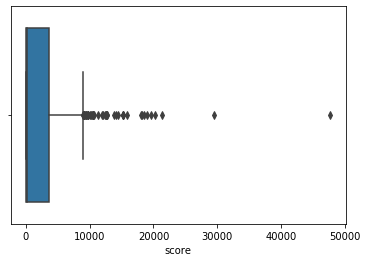

In [50]:
sns.boxplot(cons.score);

In [51]:
progs.score.describe()

count    2919.000000
mean      158.304556
std       182.583844
min         0.000000
25%         2.000000
50%        37.000000
75%       326.000000
max      1404.000000
Name: score, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


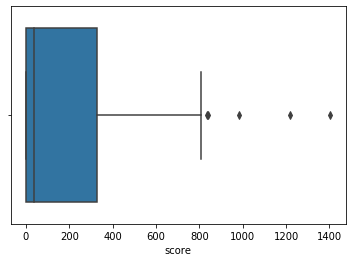

In [52]:
sns.boxplot(progs.score);

## Modelling
---

In [53]:
test = pd.read_csv('Data/tests/test.csv')

In [54]:
reddit.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'subreddit', 'gilded_user', 'sites', 'comments', 'text'],
      dtype='object')

In [55]:
test.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'subreddit', 'comments', 'text', 'sites'],
      dtype='object')

In [56]:
reddit.subreddit = reddit.subreddit.map({'Conservative':0, 'Progressive':1})
test.subreddit = test.subreddit.map({'Conservative':0, 'Progressive':1})

In [57]:
features = ['score', 'comms_num', 'text', 'sites']

#No need for train_test_split, my data is already split!
X_train = reddit[features]
X_test = test[features]

y_train = reddit.subreddit
y_test = test.subreddit

In [58]:
X_train.shape, X_test.shape

((5977, 4), (800, 4))

In [59]:
#Simplifying so that I have a fighting chance to model!
tvec = TfidfVectorizer(stop_words = 'english', max_features = 3000)
all_words_weight = tvec.fit_transform(reddit.text)
weighted_df = pd.DataFrame(all_words_weight.todense(), 
                          columns=tvec.get_feature_names())

X_train = pd.concat([X_train, weighted_df], axis = 1)
X_train.drop(columns = 'text', inplace = True)

In [60]:
X_train = pd.get_dummies(X_train, columns = ['sites'], drop_first = True)

In [61]:
X_train.shape

(5977, 4648)

In [62]:
test_words_weight = tvec.transform(test.text)
test_weighted_df = pd.DataFrame(test_words_weight.todense(), 
                          columns=tvec.get_feature_names())

X_test = pd.concat([X_test, test_weighted_df], axis = 1)
X_test.drop(columns = 'text', inplace = True)

In [63]:
X_test = pd.get_dummies(X_test, columns = ['sites'], drop_first = True)

In [64]:
X_test.shape

(800, 3278)

In [65]:
#Because some dummy variables are not equally created, a set here is made to match all columns in both
#Testing and submitting data
set1 = set(X_test.columns)
set2 = set(X_train.columns)
adds = set2.difference(set1)
len(set2.difference(set1))

1425

In [66]:
#Adding these empty columns to my test data so that the shapes match
for cols in adds:
    X_test[cols] = 0

In [67]:
adds2 = set1.difference(set2)
len(set1.difference(set2))

55

In [68]:
for cols in adds2:
    X_train[cols] = 0

In [69]:
#Putting all data in the same order so that the model compares them properly with one another
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [70]:
X_train.shape, X_test.shape

((5977, 4703), (800, 4703))

In [71]:
rf = RandomForestClassifier()

First modelling attempt: pure random forrest classifier, no gridsearching, with default parameters.

In [72]:
#Baseline accuracy score:
reddit.subreddit.value_counts(normalize = True)

0    0.511628
1    0.488372
Name: subreddit, dtype: float64

In [73]:
cross_val_score(rf, X_train, y_train).mean()

0.8614809476497671

In [74]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [75]:
rf.score(X_train, y_train)

1.0

In [76]:
rf.score(X_test, y_test)

0.8725

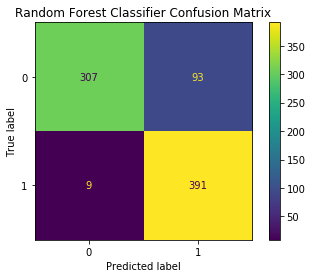

In [77]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title('Random Forest Classifier Confusion Matrix');

This is all well and good, but my goal here is not just to build a predictive model. I am trying to illustrate the reality of different word importances and news sources on people of different political ideologies. However, given the behavior of both subreddits, the number of comments and the score of each post will almost by themselves indicate to the model which subreddit a post belongs to. I should run the model again, this time using only the sites and TF-IDF vectorized words to illustrate how strong of a correlation they play as well.

In [78]:
X_train_words = X_train.drop(columns = ['score', 'comms_num'])
X_test_words = X_test.drop(columns = ['score', 'comms_num'])

In [79]:
cross_val_score(rf, X_train_words, y_train).mean()

0.8551218146961279

In [80]:
rf.fit(X_train_words, y_train)

RandomForestClassifier()

In [81]:
rf.score(X_train_words, y_train), rf.score(X_test_words, y_test)

(1.0, 0.87875)

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix: Words')

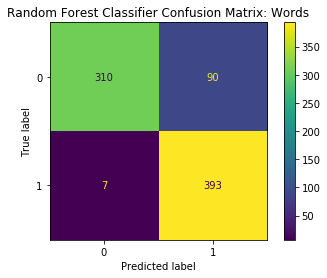

In [82]:
plot_confusion_matrix(rf, X_test_words, y_test)
plt.title('Random Forest Classifier Confusion Matrix: Words')

## Support Vector Machine Method
---

In [83]:
X_train.shape

(5977, 4703)

In [84]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [85]:
Z_train_words = sc.fit_transform(X_train_words)
Z_test_words = sc.transform(X_test_words)

In [86]:
svm = SVC(C = 2, kernel = 'poly', degree = 2)
%time svm.fit(Z_train, y_train)
#sparams = {'C':[0.01, 1]}
#gs_svm = GridSearchCV(svm, sparams, cv = 4)

CPU times: user 3min 28s, sys: 1.72 s, total: 3min 30s
Wall time: 3min 32s


SVC(C=2, degree=2, kernel='poly')

In [87]:
svm.score(Z_train, y_train), svm.score(Z_test, y_test)

(0.9956499916345993, 0.72)

In [88]:
svm.fit(Z_train_words, y_train)

SVC(C=2, degree=2, kernel='poly')

In [89]:
svm.score(Z_train_words, y_train), svm.score(Z_test_words, y_test)

(0.9956499916345993, 0.71875)

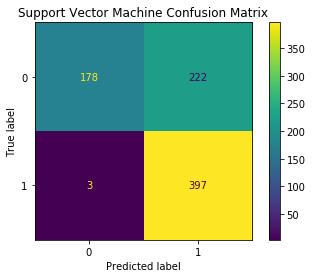

In [90]:
plot_confusion_matrix(svm, Z_test_words, y_test)
plt.title('Support Vector Machine Confusion Matrix');

### Logistic Regression Model
---

In [91]:
logreg = LogisticRegression(C = 0.01, max_iter = 200)
cross_val_score(logreg, Z_train, y_train).mean()

0.8765385315066959

In [92]:
logreg.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [93]:
params = {'C':[0.001, 0.01, 0.1, 1,10], 'solver':['liblinear'], 'penalty':['l1', 'l2']}
gs = GridSearchCV(logreg, params, cv = 5)
gs.fit(Z_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(C=0.01, max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [94]:
gs.best_params_, gs.best_score_

({'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 0.8971149298218609)

In [95]:
gs.score(Z_train, y_train), gs.score(Z_test, y_test)

(0.9958172996486532, 0.9125)

In [96]:
gs.fit(Z_train_words, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(C=0.01, max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [97]:
gs.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [98]:
gs.score(Z_train_words, y_train), gs.score(Z_test_words, y_test)

(0.9958172996486532, 0.9125)

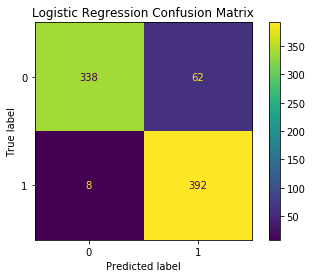

In [99]:
plot_confusion_matrix(gs, Z_test_words, y_test)
plt.title('Logistic Regression Confusion Matrix');

## Scores
---
Test data is re-pulled after each model testing. So each model is exposed to unseen data. 
A random forest gridsearch was attempted, but had to be abandoned due to time constraints (the data collected is too large). 

The models were tested on the entire dataframe, however, to better see the validity of this assessment of division among people of different ideologies (as this is the focus of this study), the data fit to the model was also adjusted. Features such as comment size and karma scores were strong predictors, however they would merely indicate evidence of behaviors specific to the reddit website. To attempt to help generalize the predictive power of this model to Americans invovled in politics on the whole, these two features are dropped to focus entirely on the words utilized in online comments, and news sites visited.

Test data was drawn periodically over a period of roughly 3 days, at least 8-10 hours apart, to give time for new posts to populate on each subreddit.

| Model results on unseen data :Test1                                    | Accuracy on all features | Accuracy on words/news sites alone |
|-----------------------------------------------------------------------|--------------------------|------------------------------------------------|
| Random Forest                                                         | 89.9%                    | 88.9%                                          |
| Support Vector Machine                                                | 77.6%                    | 77.6%                                          |
| Logistic Regression Gridsearch (C:0.1, l1 penalty, lib linear solver) | 89.6%                    | 92.6%                                          |

| Model results on unseen data:Test2                                    | Accuracy on all features | Accuracy on words/news sites alone |
|-----------------------------------------------------------------------|--------------------------|------------------------------------------------|
| Random Forest                                                         | 88.6%                    | 87.8%                                          |
| Support Vector Machine                                                | 77.4%                    | 77.4%                                          |
| Logistic Regression Gridsearch (C:0.1, l1 penalty, lib linear solver) | 91.8%                    | 90.9%                                          |

| Model results on unseen data:Test3                                    | Accuracy on all features | Accuracy on words/news sites alone  |
|-----------------------------------------------------------------------|--------------------------|------------------------------------------------|
| Random Forest                                                         | 87.8%                    | 87.8%                                          |
| Support Vector Machine                                                | 77.1%                    | 77.2%                                          |
| Logistic Regression Gridsearch (C:0.1, l1 penalty, lib linear solver) | 91.1%                    | 90.9%                                          |

| Model results on unseen data:Test4                                    | Accuracy on all features | Accuracy on words/news sites alone |
|-----------------------------------------------------------------------|--------------------------|------------------------------------|
| Random Forest                                                         | 87.6%                    | 87.1%                              |
| Support Vector Machine                                                | 72.0%                    | 71.9%                              |
| Logistic Regression Gridsearch (C:0.1, l1 penalty, lib linear solver) | 91.3%                    | 91.3%                              |

## Conclusion
---
- There were only 122 sites out of all of the 1116 news sites used as reddit news sources that are shared among the different political subreddits. That accounts for 11% of all of the unique news sites that are in the dataset. 

- Interestingly, the conservative subreddit has higher scores values in the 5 number summary in the sentiment analysis of positive scores (though not by a lot) compared to the progressive subreddit. 

- The conservative subreddit also has slightly higher negative scores for most of the 5 number summary, though the maximum negative score of the progressive subreddit is a higher value.

*Some caveats - people other than subscribers can post comments, so the sentiment of comments may not always reflect the people who post or even frequently view the various subreddits. Both subreddits appear to periodically complain of "brigading," where people opposed to their political views leave negative or even abusive comments. Whether this assertion is true, or part of a potentially interesting psychological phenomenon involving highly politically active online users on both sides of the political spectrum, is unknown, but perhaps an area that will warrant further investigation.*

- An analysis of political keywords (names of candidates and prominient politcial figures, as well as current events words) showed that most words were divisive among the groups, with each subreddit apparently discussing different topics.

- Of all models used, the Logistic Regression model performs consistently with the lowest bias and variance. Taken with findings of EDA, this study serves as evidence of a real polarization of ideas and topics of interest among political ideology groups.

- Interestingly, when a subreddit is misclassified, the model tends to falsely classify actual progressive posts as Conservative ones, and less so the other way around. This likely has to do with the higher level of activity in that subreddit, in terms of commenting and posting.

**NOTE:** Given the constantly changing poltical landscapes, topics discussed, and typical "buzzwords," it is important to note that the EDA of word choices done in this study will be irrelevant outside of the period of time of this study (October of 2020). However, the model can be retrained with new words by collecting new data in the Data_Acquisition notebook, then utilizing that data to retrain the models in this notebook. 

## Recommendations from this study
---
It would appear that there is evidence of both isolation (getting news from entirely different sources) and division (separation of topics discussed and read about) with respect to politically active people on both ends of the political spectrum. This is no mere difference of opinions - this is people having completely different conversations, reading different sources, and in essence living completely different existences in the same country. 

With this project as evidence of such division, further studies can be conducted on the effects of such divisions on those who are politcially active, potential risk factors of such political divides on individual psyches, as well as potential methods of effecting some level of compromise and coexistence among ever more separated communities.